In [4]:
import numpy as np
import pandas as pd
import os
import pathlib
import matplotlib.pyplot as plt
import seaborn

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from sklearn.metrics import classification_report, log_loss, accuracy_score

In [2]:
train_dir='/content/drive/MyDrive/archive-2/cats_dogs/train'
test_dir='/content/drive/MyDrive/archive-2/cats_dogs/test'

In [5]:
file_train = tf.io.gfile.glob(train_dir + '/*/*')
file_train = tf.random.shuffle(file_train)
train_ds=file_train

file_test = tf.io.gfile.glob(test_dir + '/*/*')
file_test = tf.random.shuffle(file_test)
test_ds=file_test

print(train_ds.shape)
print(test_ds.shape)

(210,)
(67,)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
def get_waveform_label(file):
    
    lab = tf.strings.split(file, os.path.sep)[-2]
    audio_binary = tf.io.read_file(file)
    audio, _ = tf.audio.decode_wav(audio_binary)
    waveform=tf.squeeze(audio, axis=-1)
    return waveform, lab

AUTO = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_ds)
waveform_ds = files_ds.map(get_waveform_label, num_parallel_calls=AUTO)

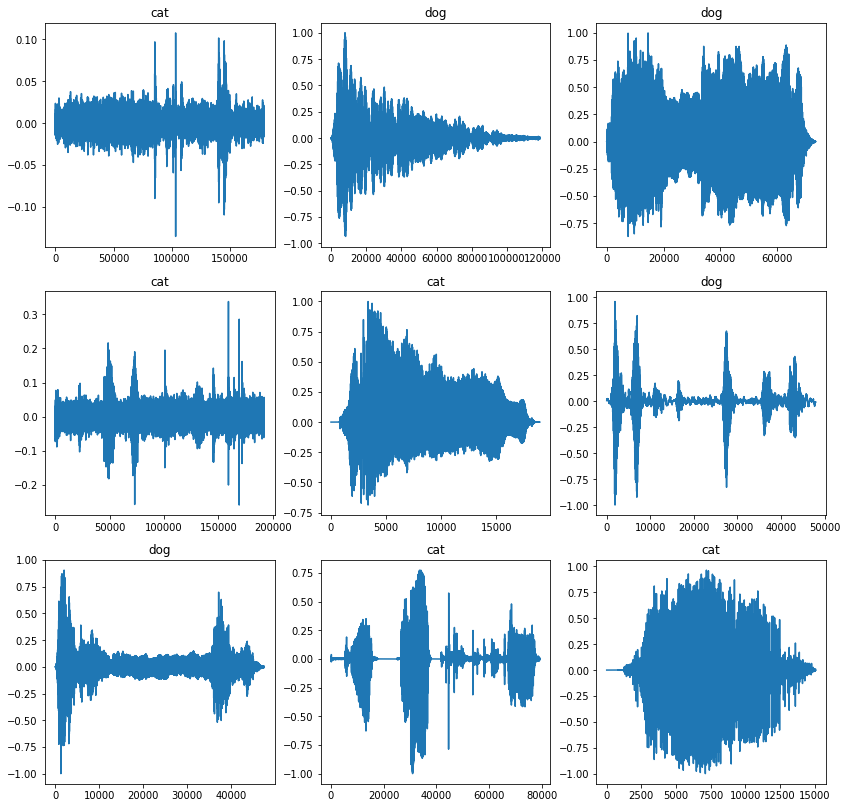

In [26]:
fig, axs = plt.subplots(3,3,figsize=(14,14))

for i, (audio,label) in enumerate(waveform_ds.take(3*3)):
    r = i//3
    c = i%3
    ax = axs[r][c]
    ax.plot(audio.numpy())
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.show()

In [8]:
def get_spectrogram_label(audio, label):

    padding = tf.zeros([300000]-tf.shape(audio), dtype=tf.float32)
    wave = tf.cast(audio, tf.float32)
    eq_length = tf.concat([wave, padding], 0)
    spectrogram = tf.signal.stft(eq_length, frame_length=210, frame_step=110)    
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == labels)
    return spectrogram, label_id

Name=["cat","dog","test"]
labels = np.array(Name)
spectrogram_ds = waveform_ds.map(get_spectrogram_label, num_parallel_calls=AUTO)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


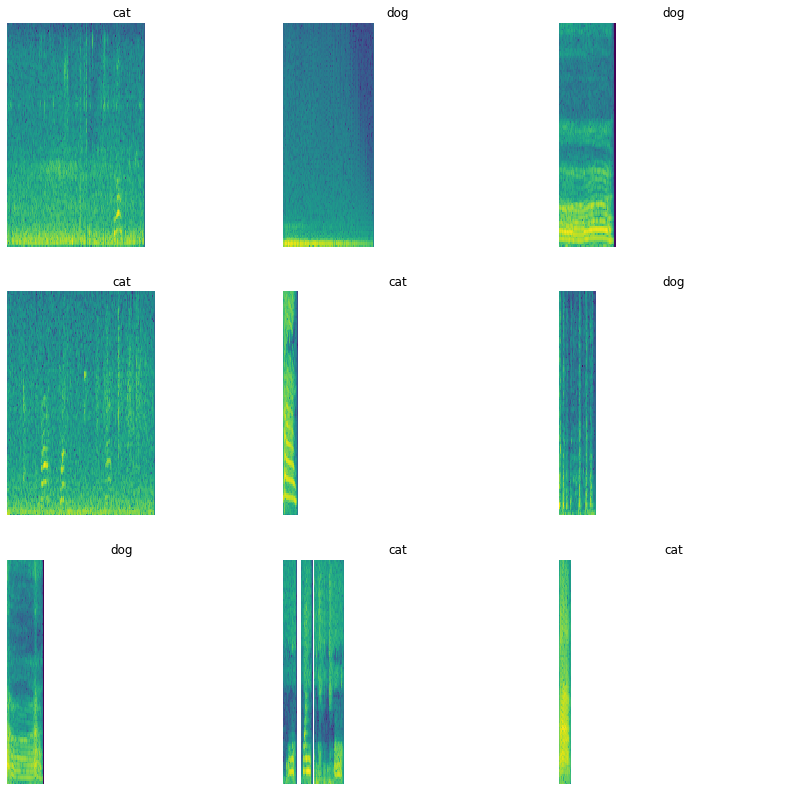

In [9]:
def plot_spect(spectrogram, ax):
    
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

fig, axes = plt.subplots(3,3, figsize=(14,14))

for i, (spectrogram,label_id) in enumerate(spectrogram_ds.take(3*3)):
    
    r = i//3
    c = i%3
    ax = axes[r][c]
    plot_spect(np.squeeze(spectrogram.numpy()), ax)
    ax.set_title(labels[label_id.numpy()])
    ax.axis('off')
    
plt.show()

In [10]:
def preprocess(file):
    
    files_ds = tf.data.Dataset.from_tensor_slices(file)
    output_ds = files_ds.map(get_waveform_label,num_parallel_calls=AUTO)
    output_ds = output_ds.map(get_spectrogram_label,num_parallel_calls=AUTO)
    return output_ds

train_ds = spectrogram_ds
test_ds = preprocess(test_ds)

In [11]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTO)

In [12]:
for spectrogram,_ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape

num_labels = len(labels)
norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

print(input_shape)
print(num_labels)

(2726, 129, 1)
3


In [13]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32,3, activation='relu'),
    layers.Dropout(0.2),
    layers.Conv2D(128,3, activation='relu'),
    layers.Dropout(0.2),    
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       36992     
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 128)       0         
                                                        

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [15]:
EPOCHS = 30
his = model.fit(train_ds,epochs=EPOCHS)

Epoch 1/30
4/4 [==============================] - 15s 3s/step - loss: 0.8045 - accuracy: 0.5000
Epoch 2/30
4/4 [==============================] - 1s 301ms/step - loss: 0.6338 - accuracy: 0.7143
Epoch 3/30
4/4 [==============================] - 1s 324ms/step - loss: 0.4520 - accuracy: 0.8333
Epoch 4/30
4/4 [==============================] - 2s 470ms/step - loss: 0.4407 - accuracy: 0.8286
Epoch 5/30
4/4 [==============================] - 2s 447ms/step - loss: 0.3446 - accuracy: 0.8810
Epoch 6/30
4/4 [==============================] - 2s 450ms/step - loss: 0.3129 - accuracy: 0.8857
Epoch 7/30
4/4 [==============================] - 2s 439ms/step - loss: 0.2960 - accuracy: 0.8857
Epoch 8/30
4/4 [==============================] - 2s 443ms/step - loss: 0.2570 - accuracy: 0.9000
Epoch 9/30
4/4 [==============================] - 2s 455ms/step - loss: 0.2188 - accuracy: 0.9238
Epoch 10/30
4/4 [==============================] - 2s 453ms/step - loss: 0.2005 - accuracy: 0.9381
Epoch 11/30
4/4 [====

In [16]:
get_acc = his.history['accuracy']
get_loss = his.history['loss']

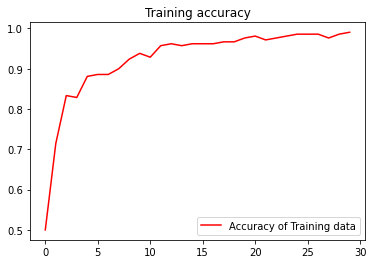

<Figure size 432x288 with 0 Axes>

In [17]:
epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.title('Training accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

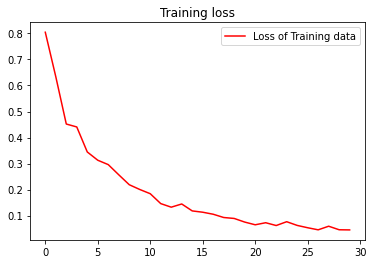

<Figure size 432x288 with 0 Axes>

In [18]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.title('Training loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [19]:
t_audio = []
t_labels = []

for audio,label in test_ds:
    t_audio.append(audio.numpy())
    t_labels.append(label.numpy())

t_audio = np.array(t_audio)
t_labels0 = np.array(t_labels)
t_labels0

array([2, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 2, 0, 2, 0, 2,
       0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2,
       0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0,
       2])

In [20]:
t_labels1=[]
for item in t_labels0:
    if item == 2:
        t_labels1+=[1]
    else:
        t_labels1+=[0]

np.array(t_labels1)

array([1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1])

In [21]:
print(t_audio.shape)
print(np.array(t_labels).shape)

(67, 2726, 129, 1)
(67,)


In [22]:
y_pred = np.argmax(model.predict(t_audio), axis=1)
y_true = np.array(t_labels1)
test_acc = sum(y_pred == y_true)/len(y_true)

print(test_acc)

0.8507462686567164


In [23]:
y_pred0=model.predict(t_audio)
y_pred=np.argmax(y_pred0,axis=1)
y_true = np.array(t_labels1)

print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.88        39
           1       0.85      0.79      0.81        28

    accuracy                           0.85        67
   macro avg       0.85      0.84      0.84        67
weighted avg       0.85      0.85      0.85        67

